In [2]:
import networkx as nx
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import sys
import functools
import itertools
import bisect
import random
from copy import deepcopy
from itertools import combinations
%matplotlib inline

In [3]:
# Load json file
with open('../resources/space.json', 'r') as f:
    rooms_json = json.load(f)

# nx.draw(G, with_labels=True, font_weight='bold')

In [13]:
gm = MuseumGraphManager(rooms_json)

KeyError: 'D14-7'

In [4]:
class MuseumGraphManager:

    def __init__(self, rooms_map, rooms_subset=None, grid_dimensions=[100,70]):

        """
        Graph of Rooms

        Parameters
        ----------
        rooms_map: map of the rooms

        """
        self.grid_dimensions = grid_dimensions
        
        self._rooms = self._prepare_room_map(rooms_map, rooms_subset=rooms_subset)
        self.room_graph = self._create_room_graph()
        self.door_graph = self._create_door_graph()

    def _prepare_room_map(self, rooms_map, rooms_subset=None):
        
        rooms_prepared = []
        rooms_filtered = filter(lambda x: x['room_name'] in rooms_subset, rooms_map) if rooms_subset is not None else rooms_map
        for room in rooms_filtered:
            
            # Extract room number
            room_number_origin = int(re.findall(r"\d+", room['room_name'])[0])
            
            # Lists to be filled with the respective adapted door and exhibit structures
            doors_prepared = []
            exhibits_prepared = []
            
            # Prepare doors
            for door in room['doors']:
                
                p_start = self._denormalize_coordinate(door['p_start'])
                p_end = self._denormalize_coordinate(door['p_end'])
                
                # Location of door as a single point (midpoint of line formed by p_start and p_end)
                location = (p_start + p_end)/2.0
                
                # Create new door dictionary based on mods made to the original.
                min_room_n, max_room_n = sorted([room_number_origin,int(door['connects_to_room'])])
                d = {"location": location,
                        "connects_to_room": door['connects_to_room'],
                        "name":"D{a}-{b}".format(a=min_room_n,
                                                 b=max_room_n)
                    }
                # Add prepared door to list of doors that make up the room
                doors_prepared.append(d)
            
            # Prepare exhibits
            for exhibit in room['exhibits']:
                
                # Create new exhibit dictionary based on mods made to the original.
                e = {
                    "location":self._denormalize_coordinate(exhibit['location']),
                    "name": exhibit['name'].replace("Exhibit ","E")    
                }
                
                # Add prepared exhibit to list of exhibits that make are inside this room
                exhibits_prepared.append(e)
            
            # Prepare the room with the prepared doors and exhibits
            r = {"room_name": room['room_name'],
                 "connected_rooms":room['connected_rooms'],
                 "doors" : doors_prepared,
                 "exhibits": exhibits_prepared
                }
            
            # Add the prepared room to the list of prepared rooms
            rooms_prepared.append(r)
        
        return rooms_prepared
                
    def _denormalize_coordinate(self,coordinate):
        """
        Denormalizes the specified coordinate, since elements from the space.json file
        are expressed as percentages.

        Parameters
        ----------
        coordinate (x,y) :

        Returns
        -------
        point (Numpy array) : denormalized coordinate.
        """
        x_max = self.grid_dimensions[0]
        y_max = self.grid_dimensions[1]

        # Denormalize
        _x = round((coordinate['x'] / 100.0) * x_max)
        _y = round((coordinate['y'] / 100.0) * y_max)

        # Make sure denormalized values stay within permitted range
        # i.e. x_max = 50 means the maximum value is not 50, but 49 (50 values 0 to 49).
        x = x_max if _x == x_max else _x
        y = y_max if _y == y_max else _y

        point = np.array((x, y))

        return point

    def _create_door_graph(self):
        """
        Create a Graph of Doors
        """
        
        # create empty graph
        g = nx.Graph()
        link_list = []
        
        for room in self._rooms: #([self._rooms[5]] + [self._rooms[12]]): 
            #[self._rooms[0]] + [self._rooms[2]] + [self._rooms[4]] + [self._rooms[5]] +  [self._rooms[12]]
            # Make all possible two pair combinations inside the room.
            # (door-door, exhibits-exhibit, door-exhibit)
            
            node_combinations = list(combinations(room['doors'] + room['exhibits'], 2))
            #print(f' Doors for {room["room_name"]}:')
            #print(room['doors'])
            #print()
            #print(f' Exhibits for {room["room_name"]}:')
            #print(room['exhibits'])
            #print('----------------------------------')
            #print()
            #print(f'Combinations for {room["room_name"]}:')
            for node1, node2 in node_combinations:
                
                distance = np.linalg.norm(node1['location'] - node2['location'])
                n1, n2 = node1['name'], node2['name']
                link = (n1, n2, {'weight': np.around(distance,2), 'pheromone': 0.9})
                #print(link)
                link_list.append(link)

        # Add links to graph (this automatically creates nodes)
        g.add_edges_from(link_list)
        g = self.add_missing_edges_graph(g)
        return g
        
    def add_missing_edges_graph(self, g):
        """
        Add edges to all pairs of nodes that do not already have an edge in the graph.
        :param graph: NetworkX graph.
        """
        nodes = list(g.nodes())
        link_list = []
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                if not g.has_edge(nodes[i], nodes[j]):
                    link =  (nodes[i], nodes[j], {'weight': 0 , 'pheromone':0})
                    link_list.append(link)
        
        g.add_edges_from(link_list)
        return g
    
    def initialise_pheromones(self, graph, rho=None):
        # cost_nn_heuristic = self._nearest_neighbor_heuristic(graph, start, objectives)
        initial_pheromone_value = 0.9 # 1.0/(rho*cost_nn_heuristic)
        for edge in graph.edges():
            u,v = edge
            pher_val = graph[u][v]['pheromone']
            graph[u][v]['pheromone'] = initial_pheromone_value if pher_val > 0 else 0
            
            # door-door links must have phermone
            # if 'D' in u and 'D' in v:
            #     graph[u][v]['pheromone'] = initial_pheromone_value
            
            # exhibit-exhibit links that involve the objectives must have pheromone
            #elif (u in objectives and v in objectives):
            #    graph[u][v]['pheromone'] = initial_pheromone_value 
            
            # exhibit-door links that involve objectives must have pheromone
            # elif (u in objectives or v in objectives) and ('D' in u or 'D' in v):
            #    graph[u][v]['pheromone'] = initial_pheromone_value
            
            # links that are initially not relevant
            # some of these will later be significant as the visitor travels towards interesting exhibits
            # not located in the initial objectives
            # else:
            #     graph[u][v]['pheromone'] = 0
                
        
    def _create_room_graph(self):
        """
        Create a Graph of Rooms.
        This is a simple graph.
        
        """

        # create empty graph
        g = nx.Graph()
        link_list = []
        # dist = np.linalg.norm(point1 - point2)
        
        for room in self._rooms:
            room_number = re.findall(r"\d+", room['room_name'])[0]
            for node in room['connected_rooms']:
                link = (int(room_number), node, {'weight': 1})
                link_list.append(link)

        # Add links to graph (automatically creates nodes)
        g.add_edges_from(link_list)
        return g

    def get_shortest_path(self, graph, origin, dest):
        return nx.shortest_path_length(graph, source=origin, target=dest, weight='weight')
    
    def get_neighbors(self,graph, node, neighbor_type=""):
        
        if(neighbor_type == 'door'):
            return [name for name, props in graph[node].items() if "D" in name ] 
        elif (neighbor_type == 'exhibit'):
            return [name for name, props in graph[node].items() if "E" in name ] 
        else:
            return graph[node]
    
    
    def _nearest_neighbor_heuristic(self, graph, start, objectives):
        sps = [nx.shortest_path_length(graph, source=start,
                                           target=objective, weight='weight') for objective in objectives]
        furthest_exhibit = max(sps)
        sum_paths = sum(sps)
        estimated_cost = sum_paths/1.8
        #print(estimated_cost)
        return estimated_cost
    
    def plot(self, graph, edge_attribute='weight'):
        pos = nx.spring_layout(graph)
        plt.figure(figsize=(15,15))
        attribute_labels = nx.get_edge_attributes(graph,edge_attribute)
        nx.draw(graph,pos,edge_color='black',width=1,linewidths=1,node_size=500,
                node_color='pink',alpha=0.9,labels={node:node for node in graph.nodes()})
        nx.draw_networkx_edge_labels(graph,pos,edge_labels=attribute_labels,font_color='red')
        plt.axis('off')
        plt.show()

In [421]:
@functools.total_ordering
class Solution:
    
    def __init__(self,graph,start, ant=None):
        self.graph = graph
        self.start = start
        self.current = start
        self.previous = start
        self.cost = 0
        self.path = []
        self.nodes = [start]
        self.visited_nodes = set(self.nodes)
        
    def __iter__(self):
        return iter(self.path)
    
    def __eq__(self, other):
        return self.cost == other.cost
    
    def __lt__(self, other):
        return self.cost < other.cost
    
    def __contains__(self,node):
        return node in self.visited_nodes or node == self.current
        
    def add_node(self, node):
        self.nodes.append(node)
        self.visited_nodes.add(node)
        self._add_node(node)
        
    def _add_node(self, node):
        edge = self.current, node
        edge_attributes = self.graph[self.current][node]
        self.path.append(edge)
        self.cost += edge_attributes['weight']
        self.previous = self.current
        self.current = node
    
    def close(self):
        self._add_node(self.start)
        
        

In [422]:
class Ant:
    
    def __init__(self,alpha=1, beta=3):
        self.alpha = alpha
        self.beta = beta
        
    def construct_tour(self, graph):
        """
        Construct a tour including all chosen exhibits
        """
        start = random.choice(list(graph.nodes))
        solution = Solution(graph, start, ant=self)
        unexplored = self._get_unexplored_nodes(graph,solution)
        
        while unexplored:
            node = self._choose_destination(graph, solution.current, unexplored)
            # print(f"chosen node = {node}")
            solution.add_node(node)
            # print(f"Unvisited before = {unexplored}")
            unexplored.remove(node)
            # print(f"Unvisited after = {unexplored}")
        solution.close()
        return solution
    
    
    def _get_unexplored_nodes(self,graph, solution):
        """
        Returns the possible transition nodes (neighbors) for the current node.
        """
        return [name for name, _ in graph[solution.current].items() if name not in solution]
        # return [n for n in graph.nodes() if n not in solution]
        
    
    def _choose_destination(self, graph, current, unvisited):
        """
        Returns next node to visit
        """
        if len(unvisited) == 1:
            return unvisited[0]
        scores = self._get_scores(graph, current, unvisited)
        return self._choose_node(unvisited, scores)
    
    def _get_scores(self, graph, current, destinations):
        """
        Return scores for the given destinations
        """
        scores = []
        for node in destinations:
            edge = graph[current][node]
            score = self._score_edge(edge)
            scores.append(score)
        return scores
    
    def _choose_node(self, choices, scores):
        """
        Return one of the choices
        """
        total = sum(scores)
        cumdist = list(itertools.accumulate(scores)) + [total]
        chosen_node_index = bisect.bisect(cumdist, random.random()*total)
        return choices[min(chosen_node_index, len(choices) - 1)]
    
    def _score_edge(self,edge):
        
        weight = edge['weight']
        pheromone = edge['pheromone']
        
        if weight == 0:
            return sys.float_info.max
        eta = 1.0/weight
        tau = pheromone
        
        return (tau**self.alpha)*(eta**self.beta)
       

In [423]:
class Colony:
    
    def __init__(self, alpha=1, beta=3):
            self.alpha = alpha
            self.beta = beta
    
    def __repr__(self):
        return(f'{self.__class__.__name__}(alpha={self.alpha}, beta={self.beta})')
        
    def get_ants(self,num_ants):
        return [Ant(**vars(self)) for i in range(num_ants)]

In [424]:
class State:
    def __init__(self, graph, ants, limit, n_ants, colony):
        self.graph = graph
        self.ants = ants
        self.current_iteration = 0
        self.current_upper_bound = 0
        self.current_lower_bound = 0
        self.limit = limit
        self.colony = colony
        self.solutions = None
        self.record = None
        self.previous_record = None
        self.is_new_record = False
        self.best = None
        self.best_iteration = 0
        self.last_smoothing_iteration = 0
        
        self.start = None
        self.objectives = None
        
    def set_best(self,best,iteration):
        self.is_new_record = self.record is None or best < self.record
        if self.is_new_record:
            self.previous_record = self.record
            self.record = best
            self.best_iteration = iteration
        self.best = best

In [425]:
import random
import math
from collections import Counter

class Solver:
    
    def __init__(self, rho=0.02, pts_factor=0.1, pBest = 0.05, pts=True, state=None, print_msg=False):
        self.rho = rho
        self.pts_factor = pts_factor
        self.pBest = pBest
        self.pts = pts
        self.state = state
        self.print_msg = print_msg
    
    
    def __repr__(self):
        return (f'{self.__class__.__name__}(rho={self.rho}, pts_factor={pts_factor})')
    
    def solve(self, graph, colony = None, n_ants=None, limit=None):
        #best = None
        #for solution in self.optimize(graph, colony, n_ants, limit, start, objectives):
        #    best = solution
        #return self.state, best
        self.optimize(graph, colony, n_ants, limit)
        return self.state
    
    def optimize(self, graph, colony, n_ants, limit):

        if not self.state:
            ants = colony.get_ants(n_ants)
            state = State(graph=graph,ants=ants, limit=limit,n_ants=n_ants,colony=colony)
        else:
            state = self.state
            ants = state.ants
            
        #loop to yield increasingly better solutions
        looper = range(state.current_iteration, limit + state.current_iteration) if limit is not None else itertools.count()

        for i in looper:
            
            # print(f'Current Iteration: {i}')
            solutions = self._construct_solutions(state)
            
            #print(f'Iteration {i}: GRAPH BEFORE UPDATE')
            #for node1, node2, data in graph.edges.data():
            #    print(f'{node1}-{node2}:{data}')
            #print()
        
            solutions, ants = self._order_solutions_ants(solutions,ants)
            
            #print(f'Iteration {i}: AFTER ORDERING')
            #for s in solutions_ordered_costs:
            #    print(s.cost)
            #print()
    
            state.solutions, state.ants = solutions, ants
        
            iteration_best_solution = state.solutions[0]
            state.set_best(iteration_best_solution, i)

            self._update_pheromones(state)
            
            #print(f'Iteration {i} best solution:')
            #print(iteration_best_solution.cost)
            #print(iteration_best_solution.path)
            #print()
            
            #print(f'Iteration {i}: GRAPH AFTER PHEROMONE UPDATE')
            #for node1, node2, data in graph.edges.data():
            #    print(f'{node1}-{node2}:{data}')
            #print("----------------------")
            #print()
            
            if state.is_new_record:
                pass
                # print(f'path: {state.best.path}')
                # print("----------------------")
                # print()
                #yield state.record
            state.current_iteration = i + 1
        
        self.state = state
        
        
    def _construct_solutions(self,state):
        return [ant.construct_tour(state.graph) for ant in state.ants]
     
    def _order_solutions_ants(self,solutions,ants):
        # We need to order the solutions found by their cost (and still know its associated ant)
        data = list(zip(solutions, range(len(ants)), ants))
        data.sort()
        # Ordered list of solutions and their corresponding ants
        solutions_ordered_costs, _ , ants = zip(*data)
        
        return solutions_ordered_costs, ants
        
    def _update_pheromones(self, state):
        
        best_solution = self._best_solution_type_choice(state)
            
        for edge in state.graph.edges:
            
            # Evaporate and increase pheromone trails
            self._evaporate_and_increase_pheromone_trails(state,edge, best_solution)
            
            # Update pheromone trail lower and upper bounds
            self._adjust_pheromone_trail_limits(state,edge, best_solution)
            
            # Pheromone trail smoothing
            # self._pheromone_trail_smoothing(state,edge)
    
    def sigmoid(self, x, a=1, b=1):
        # Sigmoid-like function with parameters 'a' and 'b'
        return 1 / (1 + math.exp(-a * (x - b)))

    def biased_weighted_random(self,number):
        # Use the sigmoid-like function to calculate the threshold
        # Bias max at 300
        threshold = self.sigmoid(number, a=0.02, b=150)  # Adjust 'a' and 'b' for desired bias
    
        # Generate a random number between 0 and 1
        random_number = random.random()
    
        # Compare the random number to the threshold
        if random_number < threshold:
            return 'global_best'
        else:
            return 'iteration_best'
            
    def _best_solution_type_choice(self, state):
        #Choose between global best and iteration best
        choices = {'iteration_best': state.solutions[0], 'global_best': state.record}
        t = state.current_iteration
        type = self.biased_weighted_random(t)
        # choice_made = print(f'{type} used at iteration {t}')
        return choices[type]
        
    
    def __best_solution_type_choice(self,state):
        
        #Choose between global best and iteration best
        
        t = state.current_iteration

        if t <= 25:
            global_best_frequency = 0
        elif 25 < t <= 75 :
            global_best_frequency = 8
        elif 75 < t <= 125 :
            global_best_frequency = 5
        elif 125 < t <= 250:
            global_best_frequency = 4
        else:
            global_best_frequency = 3
        
        if global_best_frequency > 0 and t % global_best_frequency == 0 :
            best_solution = state.record
            #print(f'Global best solution (it {t})')
        else:
            best_solution = state.solutions[0]
            #print(f'Iteration best solution (it {t})')
        
        return best_solution
        
        
    def _evaporate_and_increase_pheromone_trails(self,state,edge, best_solution):
        
        best_length = best_solution.cost
        
        pheromone_increase = 0
        old_pheromone = state.graph.edges[edge]['pheromone']
        
        # Only increase pheromone in edges that are relevant
        if edge in best_solution.path: # and old_pheromone != 0 :
            pheromone_increase = 1.0/best_length
        
        state.graph.edges[edge]['pheromone'] = (1 - self.rho) * old_pheromone + pheromone_increase
                
    
    def _adjust_pheromone_trail_limits(self,state,edge, best_solution):
        
    
        # Adjust pheromone trails to limits
        updated_pheromone_trail = state.graph.edges[edge]['pheromone']
        
        if updated_pheromone_trail != 0:
            
            best_length = best_solution.cost
            n = len(state.graph.nodes())
            
            upper_bound = 1.0/((1 - self.rho) * best_length)
            lower_bound = ( upper_bound * (1.0 - (self.pBest ** (1.0/n))) ) / ( ((n/2.0) - 1)*(self.pBest ** (1.0/n)) )
            
            #print(f' Upper bound: {upper_bound}')
            #print(f' Lower bound: {lower_bound}')
            
            if updated_pheromone_trail < lower_bound:
                updated_pheromone_trail = lower_bound
                
            elif updated_pheromone_trail > upper_bound:
                updated_pheromone_trail = upper_bound
                
            else:
                updated_pheromone_trail = updated_pheromone_trail
            
            state.graph.edges[edge]['pheromone'] = updated_pheromone_trail
            
            state.current_upper_bound = upper_bound
            state.current_lower_bound = lower_bound
            
    
    def _pheromone_trail_smoothing(self,state, edge):
        
        # PTS lift-minimum approach
        freq = 50
        pheromone_trail = state.graph.edges[edge]['pheromone']
        
        cond1 = self.pts
        cond2 = abs(state.best_iteration - state.current_iteration) >= freq
        cond3 = abs(state.last_smoothing_iteration - state.current_iteration ) >= freq
        cond4 = pheromone_trail != 0
        
        if cond1 and cond2 and cond3 and cond4:
            print("smoothing")
            state.last_smoothing_iteration = state.current_iteration
            smoothing_factor = self.pts_factor
            lower_bound = state.current_lower_bound
            upper_bound = state.current_upper_bound
            new_lower_bound = lower_bound + smoothing_factor*(upper_bound - lower_bound)
            
            pheromone_trail = state.graph.edges[edge]['pheromone']
                _config_graph
            if pheromone_trail < new_lower_bound:
                
                pheromone_trail = lower_bound
                state.graph.edges[edge]['pheromone'] = pheromone_trail
            
            state.current_lower_bound = new_lower_bound
        
            #pheromone trail reinitialization
            # tengo que explorarlo, o cojo la formula (un poco movida) o compruebo si no mejora la
            #busqueda en x iteraciones, y con ese criterio sencillo digo que reinicio los trails
            

In [426]:
from copy import deepcopy
class AlgorithmController:
    
    def __init__(self, graph_manager=None, alpha=1, beta=3,
                 rho=0.02, pts=False, pts_factor=0.5, num_ants=100):
        
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.pts = pts
        self.pts_factor = pts_factor
        self.num_ants = num_ants
        self.graph = self._config_graph(graph_manager)
       
        self.algorithm_states = []
        
    
    def _config_graph(self, graph_manager):
        g = graph_manager.door_graph
        graph_manager.initialise_pheromones(g)
        return g
    
    def compute_initial_iterations(self, limit=200):
        
        print(f'Starting mmas algorithm with {limit} initial iterations.')
        
        colony = Colony(alpha=self.alpha, beta=self.beta)
        solver = Solver(rho=self.rho, pts=self.pts, pts_factor=self.pts_factor)
        state = solver.solve(self.graph, colony=colony,
                     n_ants=self.num_ants, limit=limit)
        self.graph = state.graph
        self.algorithm_states.append(state)
    
    def compute_next_iterations(self, limit = 200):
        
        if not self.algorithm_states:
            raise Exception("No saved states. You must run the algorithm for the first time using start()")
        
        print(f'Continuing mmas algorithm execution with {limit} more iterations.')    
        # Retrieve the  most recent state
        last_state = deepcopy(self.algorithm_states[-1])
        solver = Solver(rho=self.rho, pts=self.pts, pts_factor=self.pts_factor, state=last_state)
        next_state = solver.solve(self.graph, limit = limit)
        self.graph = next_state.graph
        self.algorithm_states.append(next_state)
    
    def manual_pheromone_update(self,edge):
        u,v = edge
        self.graph[u][v]['pheromone'] *= 5
    
    def pheromone_info(self, edges=[]):
        if not edges:
            for u,v in controller.graph.edges():
                print(f'Edge {u}->{v}, pheromone: {controller.graph[u][v]["pheromone"]}')
        else:
            for edge in edges:
                u,v = edge
                print(f'Edge {u}->{v}, pheromone: {controller.graph[u][v]["pheromone"]}')       

In [427]:
#Parameters
gm = MuseumGraphManager(rooms_json)
params = {
    'graph_manager': gm,
    'alpha' : 1,
    'beta': 1,
    'rho' : 0.02,
    'pts': True,
    'pts_factor':1,
    'num_ants': len(gm.door_graph.nodes())
}

initial_iterations = 10
next_iterations = 5

In [431]:
import copy
g2a = copy.deepcopy(gm.door_graph)
g2a.nodes()

NodeView(('D1-1', 'D1-5', 'D1-8', 'D1-2', 'D1-6', 'D1-13', 'D1-10', 'The Annunciation', 'Las Meninas', 'The Nobleman with his Hand on his Chest', 'Las tres Gracias', 'The Garden of Earthly Delights', 'D2-3', 'D2-4', 'D2-11', "Jacob's Dream", 'D3-5', 'D3-4', 'Self-portrait', 'D4-5', 'The Immaculate Conception', 'The Cardinal', 'D6-13', 'D6-7', 'David with the Head of Goliath', 'D7-14', 'D7-8', 'D7-9', 'The Surrender of Breda', 'Judith at the Banquet of Holofernes', 'Venus and Adonis', 'D10-11', 'D10-12', 'The 3rd of May 1808 in Madrid, or “The Executions”', 'Hercules fighting the Nemean Lion', 'D11-12', 'The Crucifixion', 'Christ falls on the Way to Calvary', 'Guitar and Newspaper', 'A la deriva', 'D13-14', 'Saturn', 'The Meadow of San Isidro', 'Landscape with Psyche and Jupiter', 'D14-15', 'Guernica', 'Gaspar de Guzmán, Count-Duke of Olivares, on Horseback'))

In [57]:
gm = MuseumGraphManager(rooms_json, rooms_subset=["room_13"])
# door_graph = gm.door_graph
# door_graph.edges(data=True)

In [414]:
gm = MuseumGraphManager(rooms_json, rooms_subset=["room_6", "room_13"])
params = {
    'graph_manager': gm,
    'alpha' : 1,
    'beta': 2,
    'rho' : 0.02,
    'pts': True,
    'pts_factor':1,
    'num_ants': len(gm.door_graph.nodes())
}

initial_iterations = 50
next_iterations = 5

In [384]:
bb = [q for q in gm.door_graph.neighbors('D1-6')]
bb

['D6-13',
 'D6-7',
 'David with the Head of Goliath',
 'D1-13',
 'D13-14',
 'Saturn',
 'The Meadow of San Isidro',
 'Landscape with Psyche and Jupiter']

In [390]:
gm.door_graph.edges(data=True)

EdgeDataView([('D1-6', 'D6-13', {'weight': 205.18, 'pheromone': 0.9}), ('D1-6', 'D6-7', {'weight': 331.06, 'pheromone': 0.9}), ('D1-6', 'David with the Head of Goliath', {'weight': 597.0, 'pheromone': 0.9}), ('D1-6', 'D1-13', {'weight': 99999999999999, 'pheromone': 0}), ('D1-6', 'D13-14', {'weight': 99999999999999, 'pheromone': 0}), ('D1-6', 'Saturn', {'weight': 99999999999999, 'pheromone': 0}), ('D1-6', 'The Meadow of San Isidro', {'weight': 99999999999999, 'pheromone': 0}), ('D1-6', 'Landscape with Psyche and Jupiter', {'weight': 99999999999999, 'pheromone': 0}), ('D6-13', 'D6-7', {'weight': 317.65, 'pheromone': 0.9}), ('D6-13', 'David with the Head of Goliath', {'weight': 468.41, 'pheromone': 0.9}), ('D6-13', 'D1-13', {'weight': 570.09, 'pheromone': 0.9}), ('D6-13', 'D6-13', {'weight': 0.0, 'pheromone': 0.9}), ('D6-13', 'D13-14', {'weight': 512.45, 'pheromone': 0.9}), ('D6-13', 'Saturn', {'weight': 780.84, 'pheromone': 0.9}), ('D6-13', 'The Meadow of San Isidro', {'weight': 693.0, '

In [220]:
# gm.plot(gm.door_graph)
nodes =[n for n in gm.door_graph.nodes()]
nodes
# return [name for name, _ in graph[solution.current].items()]

['D1-6',
 'D6-13',
 'D6-7',
 'David with the Head of Goliath',
 'D1-13',
 'D13-14',
 'Saturn',
 'The Meadow of San Isidro',
 'Landscape with Psyche and Jupiter']

In [86]:
gm.door_graph['D10-1']

KeyError: 'D10-1'

In [183]:
gm = MuseumGraphManager(rooms_json)
params = {
    'graph_manager': gm,
    'alpha' : 1,
    'beta': 2,
    'rho' : 0.02,
    'pts': True,
    'pts_factor':1,
    'num_ants': len(gm.door_graph.nodes())
}

initial_iterations = 10
next_iterations = 5

In [415]:
controller = AlgorithmController(**params)
print(f"N ants: {len(gm.door_graph.nodes())}")
controller.compute_initial_iterations(limit=1000)

N ants: 9
Starting mmas algorithm with 1000 initial iterations.


/tmp/ipykernel_76432/1181033606.py:58: RuntimeWarning: overflow encountered in double_scalars
  total = sum(scores)
/tmp/ipykernel_76432/1181033606.py:59: RuntimeWarning: overflow encountered in double_scalars
  cumdist = list(itertools.accumulate(scores)) + [total]


In [417]:
state = controller.algorithm_states[0]
cost_best_result = state.record.cost
path_best_result = state.record.path
print(f"Best result cost: {cost_best_result}")
print("Path best result:")
print(path_best_result)

Best result cost: 2421.69
Path best result:
[('D1-13', 'David with the Head of Goliath'), ('David with the Head of Goliath', 'D6-7'), ('D6-7', 'D1-6'), ('D1-6', 'Landscape with Psyche and Jupiter'), ('Landscape with Psyche and Jupiter', 'D6-13'), ('D6-13', 'D13-14'), ('D13-14', 'The Meadow of San Isidro'), ('The Meadow of San Isidro', 'Saturn'), ('Saturn', 'D1-13')]


In [82]:
controller.pheromone_info()

Edge D1-1->D1-5, pheromone: 0.9
Edge D1-1->D1-8, pheromone: 0.9
Edge D1-1->D1-2, pheromone: 0.9
Edge D1-1->D1-6, pheromone: 0.9
Edge D1-1->D1-13, pheromone: 0.9
Edge D1-1->D1-10, pheromone: 0.9
Edge D1-1->The Annunciation, pheromone: 0.9
Edge D1-1->Las Meninas, pheromone: 0.9
Edge D1-1->The Nobleman with his Hand on his Chest, pheromone: 0.9
Edge D1-1->Las tres Gracias, pheromone: 0.9
Edge D1-1->The Garden of Earthly Delights, pheromone: 0.9
Edge D1-5->D1-8, pheromone: 0.9
Edge D1-5->D1-2, pheromone: 0.9
Edge D1-5->D1-6, pheromone: 0.9
Edge D1-5->D1-13, pheromone: 0.9
Edge D1-5->D1-10, pheromone: 0.9
Edge D1-5->The Annunciation, pheromone: 0.9
Edge D1-5->Las Meninas, pheromone: 0.9
Edge D1-5->The Nobleman with his Hand on his Chest, pheromone: 0.9
Edge D1-5->Las tres Gracias, pheromone: 0.9
Edge D1-5->The Garden of Earthly Delights, pheromone: 0.9
Edge D1-5->D3-5, pheromone: 0.9
Edge D1-5->D4-5, pheromone: 0.9
Edge D1-5->The Cardinal, pheromone: 0.9
Edge D1-8->D1-2, pheromone: 0.9
Edge

In [308]:
import tsplib95
problem = tsplib95.load_problem('calibration_tsp/ulysses16.tsp')
solution = tsplib95.load_solution('calibration_tsp/ulysses16.opt.tour')
print(f'Best tour: {solution.tours}')
problem.trace_tours(solution.tours)
gm = MuseumGraphManager([])
gm.door_graph = problem.get_graph()

params = {
    'graph_manager': gm,
    'alpha' : 1,
    'beta': 1,
    'rho' : 0.02,
    'pts': True,
    'pts_factor':1,
    'num_ants': len(gm.door_graph.nodes())
}

initial_iterations = 50
next_iterations = 5


Best tour: [[1, 14, 13, 12, 7, 6, 15, 5, 11, 9, 10, 16, 3, 2, 4, 8]]


/tmp/ipykernel_76432/594753610.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) load_problem. (Will be removed in newer versions. Use `tsplib95.load` instead.) -- Deprecated since version 7.0.0.
  problem = tsplib95.load_problem('calibration_tsp/ulysses16.tsp')
/tmp/ipykernel_76432/594753610.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) load_solution. (Will be removed in newer versions. Use `tsplib95.load` instead.) -- Deprecated since version 7.0.0.
  solution = tsplib95.load_solution('calibration_tsp/ulysses16.opt.tour')


## <b>Calibration Ulysses 16 TSP</b>

In [360]:
def baseline_calibration(problem_path, solution_path, best_sol_known=1272, N_times=5):
    
    problem = tsplib95.load_problem(problem_path)
    best_solution = tsplib95.load_solution(solution_path)
    min_cost_best_sol = best_sol_known
    
    cost_best_results = []
    iteration_where_best_results_occurs = []

    for i in range(1,N_times + 1):
        print(f"Run No. {i}/{N_times}")
        gm = MuseumGraphManager([])
        gm.door_graph = problem.get_graph()
        params = {
            'graph_manager': gm,
            'alpha' : 1,
            'beta': 1,
            'rho' : 0.02,
            'pts': True,
            'pts_factor':1,
            'num_ants':  len(gm.door_graph.nodes()) # 15 # len(gm.door_graph.nodes())
        }
        problem = tsplib95.load_problem(problem_path)
        solution = tsplib95.load_solution(solution_path)
        gm = MuseumGraphManager([])
        gm.door_graph = problem.get_graph()
        
        controller = AlgorithmController(**params)
        controller.compute_initial_iterations(limit=1000)
        state = controller.algorithm_states[0]
        cost_best_results.append(state.record.cost)
        iteration_where_best_results_occurs.append(state.best_iteration)

    avg_r = sum(cost_best_results)/len(cost_best_results) 
    pct_dev = ((avg_r - min_cost_best_sol)/avg_r)*100
    avg_iters = sum(iteration_where_best_results_occurs)/len(iteration_where_best_results_occurs)
    
    print(f"MMAS Average Cost: {avg_r}; Optimum : {min_cost_best_sol}; Deviation from Optimum {pct_dev}%; Average Iterations needed to yield best cost: {avg_iters}")
    return avg_r, pct_dev

    
    
        
        
    
    

In [363]:
problem_path = 'calibration_tsp/ulysses16.tsp'
solution_path = 'calibration_tsp/ulysses16.opt.tour'
baseline_calibration(problem_path, solution_path, best_sol_known=6859, N_times=1)

/tmp/ipykernel_76432/15359956.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) load_problem. (Will be removed in newer versions. Use `tsplib95.load` instead.) -- Deprecated since version 7.0.0.
  problem = tsplib95.load_problem(problem_path)
/tmp/ipykernel_76432/15359956.py:4: DeprecationWarning: Call to deprecated function (or staticmethod) load_solution. (Will be removed in newer versions. Use `tsplib95.load` instead.) -- Deprecated since version 7.0.0.
  best_solution = tsplib95.load_solution(solution_path)
/tmp/ipykernel_76432/15359956.py:23: DeprecationWarning: Call to deprecated function (or staticmethod) load_problem. (Will be removed in newer versions. Use `tsplib95.load` instead.) -- Deprecated since version 7.0.0.
  problem = tsplib95.load_problem(problem_path)
/tmp/ipykernel_76432/15359956.py:24: DeprecationWarning: Call to deprecated function (or staticmethod) load_solution. (Will be removed in newer versions. Use `tsplib95.load` instead.) -- Deprecat

Run No. 1/1
Starting mmas algorithm with 1000 initial iterations.
MMAS Average Cost: 6859.0; Optimum : 6859; Deviation from Optimum 0.0%; Average Iterations needed to yield best cost: 437.0


(6859.0, 0.0)

In [178]:
problem_path = 'calibration_tsp/eil76.tsp'
solution_path = 'calibration_tsp/eil76.opt.tour'

baseline_calibration(problem_path, solution_path, best_sol_known=538, N_times=1)

/tmp/ipykernel_76432/221327941.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) load_problem. (Will be removed in newer versions. Use `tsplib95.load` instead.) -- Deprecated since version 7.0.0.
  problem = tsplib95.load_problem(problem_path)
/tmp/ipykernel_76432/221327941.py:4: DeprecationWarning: Call to deprecated function (or staticmethod) load_solution. (Will be removed in newer versions. Use `tsplib95.load` instead.) -- Deprecated since version 7.0.0.
  best_solution = tsplib95.load_solution(solution_path)
/tmp/ipykernel_76432/221327941.py:23: DeprecationWarning: Call to deprecated function (or staticmethod) load_problem. (Will be removed in newer versions. Use `tsplib95.load` instead.) -- Deprecated since version 7.0.0.
  problem = tsplib95.load_problem(problem_path)
/tmp/ipykernel_76432/221327941.py:24: DeprecationWarning: Call to deprecated function (or staticmethod) load_solution. (Will be removed in newer versions. Use `tsplib95.load` instead.) -- Depr

Run No. 1/1
Starting mmas algorithm with 1000 initial iterations.
MMAS Average Cost: 655.0; Optimum : 538; Deviation from Optimum 17.862595419847327%; Average Iterations needed to yield best cost: 374.0


(655.0, 17.862595419847327)

In [29]:
state = controller.algorithm_states[0]
state.best.path

[(8, 1),
 (1, 16),
 (16, 3),
 (3, 2),
 (2, 4),
 (4, 10),
 (10, 14),
 (14, 13),
 (13, 12),
 (12, 15),
 (15, 5),
 (5, 9),
 (9, 11),
 (11, 6),
 (6, 7),
 (7, 8)]

In [31]:
controller.pheromone_info()

Edge 1->1, pheromone: 4.376122432629776e-06
Edge 1->2, pheromone: 4.376122432629776e-06
Edge 1->3, pheromone: 4.376122432629776e-06
Edge 1->4, pheromone: 4.376122432629776e-06
Edge 1->5, pheromone: 4.376122432629776e-06
Edge 1->6, pheromone: 4.376122432629776e-06
Edge 1->7, pheromone: 4.376122432629776e-06
Edge 1->8, pheromone: 0.00014876923214248523
Edge 1->9, pheromone: 4.376122432629776e-06
Edge 1->10, pheromone: 4.376122432629776e-06
Edge 1->11, pheromone: 4.376122432629776e-06
Edge 1->12, pheromone: 4.376122432629776e-06
Edge 1->13, pheromone: 4.376122432629776e-06
Edge 1->14, pheromone: 4.376122432629776e-06
Edge 1->15, pheromone: 4.376122432629776e-06
Edge 1->16, pheromone: 4.376122432629776e-06
Edge 2->2, pheromone: 4.376122432629776e-06
Edge 2->3, pheromone: 0.00014876923214248523
Edge 2->4, pheromone: 4.376122432629776e-06
Edge 2->5, pheromone: 4.376122432629776e-06
Edge 2->6, pheromone: 4.376122432629776e-06
Edge 2->7, pheromone: 4.376122432629776e-06
Edge 2->8, pheromone: 4

In [263]:
edges = [('D1-6', "David with the Head of Goliath")]
controller.manual_pheromone_update(edges[0])
controller.pheromone_info(edges)

Edge D1-6->David with the Head of Goliath, pheromone: 0.10453402940767824


In [374]:
edges = [('D1-6', 'E2_6'),('E2_6', 'E1_6')]
controller.manual_pheromone_update(edges[0])
controller.manual_pheromone_update(edges[1])
controller.pheromone_info(edges)

Edge D1-6->E2_6, pheromone: 0.608877074926805
Edge E2_6->E1_6, pheromone: 0.6199929074008432


In [12]:
controller.compute_next_iterations(limit=next_iterations)
controller.pheromone_info([edge])

Continuing mmas algorithm execution with 5 more iterations.
Current Iteration: 10
Current Iteration: 11
Best iteration so far: 11
cost: 116.39
path: [('D1-1', 'D1-6'), ('D1-6', 'E1_6'), ('E1_6', 'E2_6'), ('E2_6', 'D6-13'), ('D6-13', 'E3_13'), ('E3_13', 'E1_13')]
----------------------

Current Iteration: 12
Current Iteration: 13
Current Iteration: 14


NameError: name 'edge' is not defined

In [161]:
controller.algorithm_states[1].record.cost

124.61

In [27]:
saved_state = init_solver(gm, alpha=alpha, beta = beta,
                    rho = rho, pts=pts, pts_factor= pts_factor, num_ants=n_ants,
                    limit=limit, start=start,
                    objectives=objectives)

Current Iteration: 0
Best iteration so far: 0
cost: 167.35999999999999
path: [('D1-1', 'D1-8'), ('D1-8', 'D1-13'), ('D1-13', 'E3_13'), ('E3_13', 'D6-13'), ('D6-13', 'D6-7'), ('D6-7', 'E1_6'), ('E1_6', 'E2_6'), ('E2_6', 'D6-13'), ('D6-13', 'E1_13')]
----------------------

Current Iteration: 1
Current Iteration: 2
Best iteration so far: 2
cost: 115.17999999999999
path: [('D1-1', 'D1-6'), ('D1-6', 'E2_6'), ('E2_6', 'E1_6'), ('E1_6', 'D6-13'), ('D6-13', 'E3_13'), ('E3_13', 'E1_13')]
----------------------

Current Iteration: 3
Current Iteration: 4
Current Iteration: 5
Current Iteration: 6
Current Iteration: 7
Current Iteration: 8
Current Iteration: 9


In [28]:
continue_solving(saved_state,10)

NameError: name 'solver' is not defined

In [15]:
for u,v in state.graph.edges():
    print(f'edge: {u}-{v} , pheromone : {state.graph[u][v]["pheromone"]}')
print(state.current_upper_bound)
print(state.current_lower_bound)

edge: D1-1-D1-2 , pheromone : 0.00045010344661124265
edge: D1-1-D1-5 , pheromone : 0.0028991588130078748
edge: D1-1-D1-6 , pheromone : 0.36772171092163003
edge: D1-1-D1-8 , pheromone : 0.004070693784628771
edge: D1-1-D1-10 , pheromone : 0.0013003648695774693
edge: D1-1-D1-13 , pheromone : 0.003406904995192404
edge: D1-1-E1_1 , pheromone : 0.0
edge: D1-1-E2_1 , pheromone : 0.0
edge: D1-1-E3_1 , pheromone : 0.0
edge: D1-1-E4_1 , pheromone : 0.0
edge: D1-1-E5_1 , pheromone : 0.0
edge: D1-1-E6_1 , pheromone : 0.0
edge: D1-1-E7_1 , pheromone : 0.0
edge: D1-1-E8_1 , pheromone : 0.0
edge: D1-1-E9_1 , pheromone : 0.0
edge: D1-1-E10_1 , pheromone : 0.0
edge: D1-2-D1-5 , pheromone : 0.0011190136477442724
edge: D1-2-D1-6 , pheromone : 0.0012874256765632018
edge: D1-2-D1-8 , pheromone : 0.0011190136477442724
edge: D1-2-D1-10 , pheromone : 0.001304860988146367
edge: D1-2-D1-13 , pheromone : 0.0011504913844231075
edge: D1-2-E1_1 , pheromone : 0.0
edge: D1-2-E2_1 , pheromone : 0.0
edge: D1-2-E3_1 , p

In [40]:
#Hago experimentos con esto
import pandas as pd
from itertools import product

#Fixed Parameters
gm = MuseumGraphManager(rooms_json)
rho = 0.02
pts = True
pts_factor = 1
n_ants = len(gm.door_graph.nodes())
limit = 100 #100 * len(gm.door_graph.nodes())
start = 'D1-1'
objectives = ['E2_6','E10_1','E1_13','E1_10','E3_13','E8_1','E9_1','E2_10']

#Variable parameters
alphas=list(range(1,6))
betas=list(range(1,6))


# Number of tries in the experiment
N_tries = 10

experiments = []
combs = list(product(set(alphas+betas), repeat=2))
for alpha_beta in combs:
    solutions= []
    solution_paths = []
    alpha, beta = alpha_beta
    
    for _ in range(N_tries):
        state = init_solver(gm, alpha=alpha, beta = beta,
                    rho = rho, pts=pts, pts_factor= pts_factor, num_ants=n_ants,
                    limit=limit, start=start,
                    objectives=objectives)
        best = state.best
        
        solutions.append(best.cost)
        solution_paths.append(best.path)
        
    avg_cost = sum(solutions)/len(solutions)
    exp = {'alpha': alpha, 'beta': beta, 'avg_cost':avg_cost, 'paths':solution_paths}
    experiments.append(exp)

NameError: name 'init_solver' is not defined

In [198]:
experiment_df = pd.DataFrame(experiments)
# experiment_df.drop(['paths'], axis=1, inplace=True)
table = pd.pivot_table(experiment_df, values=['avg_cost'], index=['alpha'],
                    columns=['beta'])
table
#experiment_df.groupby(['alpha'])
#experiment_df.sort_values(['avg_cost'])
#experiment_df

avg_cost                    
beta         1         2         3
alpha                             
1      353.199  1256.406  1908.711

In [38]:
print(state.record.path)
print(state.record.cost)

graph = state.graph

for edge in graph.edges():
    print(f'edge: {edge}, pheromones: {graph.edges[edge]["pheromone"]}')
print('--------------------------')
print()

print("Best solution pheromone values:")
for edge in state.record.path:
    print(f'edge: {edge}, pheromones: {state.graph.edges[edge]["pheromone"]}')

[('D1-6', 'D6-7'), ('D6-7', 'E2_6'), ('E2_6', 'D6-13'), ('D6-13', 'E3_13'), ('E3_13', 'E1_13')]
79.68
edge: ('D1-6', 'D6-7'), pheromones: 0.12922268918926805
edge: ('D1-6', 'D6-13'), pheromones: 0.1497285329661182
edge: ('D1-6', 'E1_6'), pheromones: 0.0
edge: ('D1-6', 'E2_6'), pheromones: 0.019147155944323428
edge: ('D1-6', 'E3_6'), pheromones: 0.0
edge: ('D6-7', 'D6-13'), pheromones: 0.1679513655351644
edge: ('D6-7', 'E1_6'), pheromones: 0.0
edge: ('D6-7', 'E2_6'), pheromones: 0.15703465040073442
edge: ('D6-7', 'E3_6'), pheromones: 0.0
edge: ('D6-13', 'E1_6'), pheromones: 0.0
edge: ('D6-13', 'E2_6'), pheromones: 0.039184629587681735
edge: ('D6-13', 'E3_6'), pheromones: 0.0
edge: ('D6-13', 'D1-13'), pheromones: 0.024320168072509103
edge: ('D6-13', 'D13-14'), pheromones: 0.019147155944323428
edge: ('D6-13', 'D13-15'), pheromones: 0.09520726547681777
edge: ('D6-13', 'E1_13'), pheromones: 0.11440767217922304
edge: ('D6-13', 'E2_13'), pheromones: 0.0
edge: ('D6-13', 'E3_13'), pheromones: 0

In [13]:
costs = [sol.cost for sol in sols]
mc = min(costs)
mcp = costs.index(mc)
sol_min_cost = sols[mcp]
print("Minimum cost solution for the colony:")
print()
print(sol_min_cost.cost)
print()
print(sol_min_cost.path)
[print(sol.path) for sol in sols[:10]]

TypeError: 'NoneType' object is not iterable

In [46]:
graph_manager = MuseumGraphManager(rooms_json)
g = graph_manager.door_graph
ants = Colony().get_ants(10)
sols = [ant.construct_tour(g, 'D1-6',['E2_6','E1_13','E3_13']) for ant in ants]

costs = [sol.cost for sol in sols]
mc = min(costs)
mcp = costs.index(mc)
sol_min_cost = sols[mcp]

print("Minimum cost solution for the colony:")
print()
print(sol_min_cost.cost)
print()
print(sol_min_cost.path)
print(sols)

Minimum cost solution for the colony:

85.41

[('D1-6', 'E3_6'), ('E3_6', 'E2_6'), ('E2_6', 'E1_6'), ('E1_6', 'D6-13'), ('D6-13', 'E3_13'), ('E3_13', 'E2_13'), ('E2_13', 'E1_13')]
[<__main__.Solution object at 0x7fdfbd5fa5e0>, <__main__.Solution object at 0x7fdf8a366400>, <__main__.Solution object at 0x7fdf8a366f40>, <__main__.Solution object at 0x7fdf8a366f70>, <__main__.Solution object at 0x7fdf8a366d30>, <__main__.Solution object at 0x7fdf8a6d3490>, <__main__.Solution object at 0x7fdf8a6d3040>, <__main__.Solution object at 0x7fdf8a6d3160>, <__main__.Solution object at 0x7fdf8a6d31c0>, <__main__.Solution object at 0x7fdf8a6d3190>]


In [153]:
N_ANTS = 100
sols = [Ant().construct_tour(g, 'D1-6',['E1_6','E2_6','E3_6']) for i in range(1,N_ANTS + 1)]
costs = [sol.cost for sol in sols]
mc = min(costs)
mcp = costs.index(mc)
sol_min_cost = sols[mcp]

print("Minimum cost solution for the colony:")
print()
print(sol_min_cost.cost)
print()
print(sol.path)
    

        

Minimum cost solution for the colony:

34.01



NameError: name 'sol' is not defined

In [8]:
print(sol.cost)
print()
print(sol.path)
print()
print(sol.nodes)
print()
print(sol.current)

43.06

[('D1-6', 'D6-13'), ('D6-13', 'D6-7'), ('D6-7', 'E3_6'), ('E3_6', 'E2_6'), ('E2_6', 'E1_6')]

['D1-6', 'D6-13', 'D6-7', 'E3_6', 'E2_6', 'E1_6']

E1_6


In [224]:
gm = MuseumGraphManager(rooms_json)

In [107]:
simple_graph = gm.room_graph

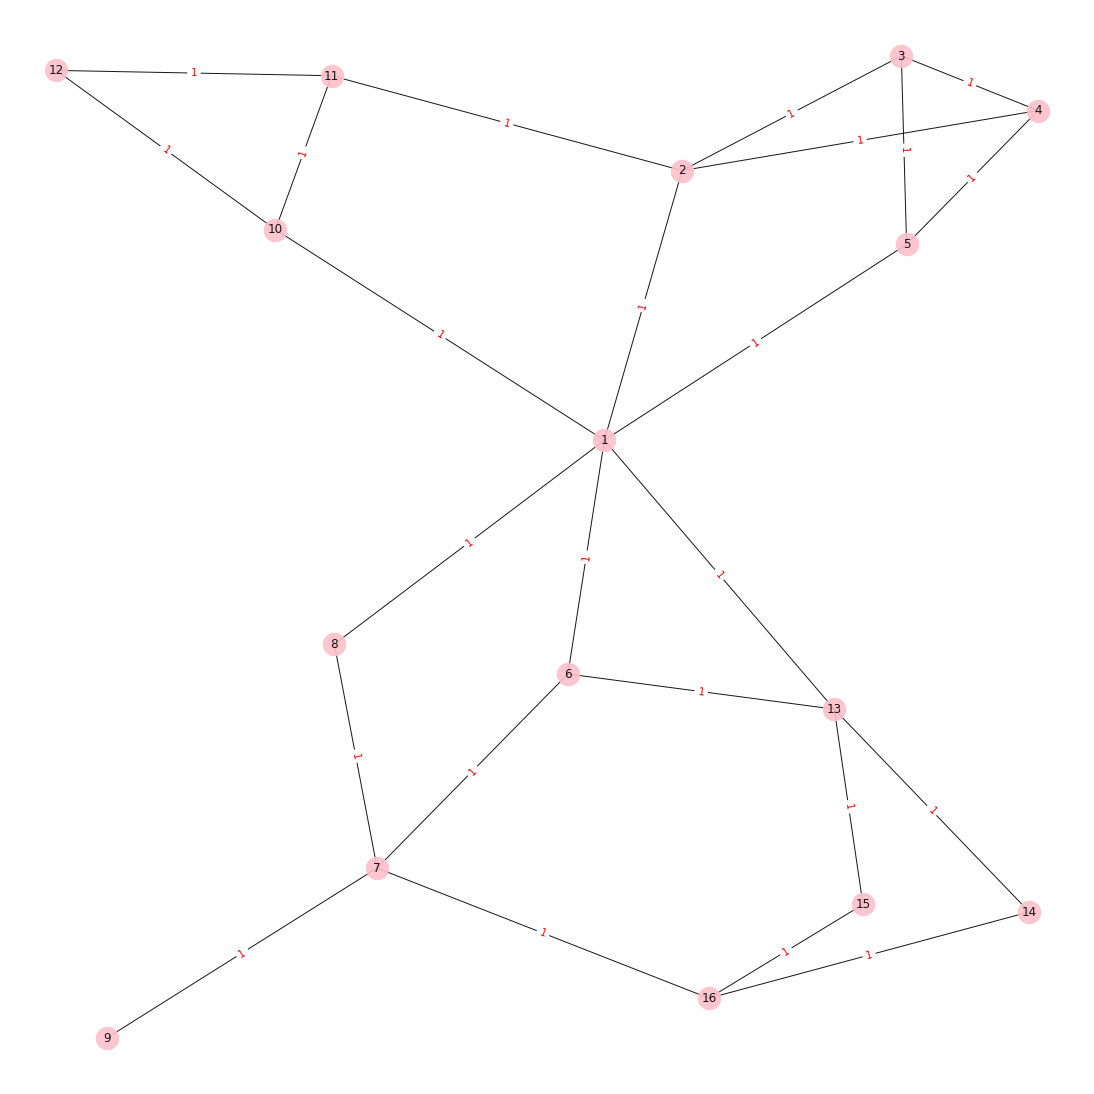

In [151]:
gm.plot(simple_graph)

In [225]:
door_graph = gm.door_graph
node_names, attribs = zip(*list(door_graph['D1-6'].items()))
weights = [attrib['weight'] for attrib in attribs ]
nearest_neighbor = node_names[weights.index(min(weights))]
print(door_graph[nearest_neighbor])

{'D1-6': {'weight': 9.43, 'pheromone': 0}, 'D6-7': {'weight': 10.77, 'pheromone': 0}, 'E1_6': {'weight': 7.07, 'pheromone': 0}, 'E2_6': {'weight': 16.76, 'pheromone': 0}, 'E3_6': {'weight': 11.4, 'pheromone': 0}, 'D1-13': {'weight': 26.4, 'pheromone': 0}, 'D13-14': {'weight': 26.93, 'pheromone': 0}, 'D13-15': {'weight': 19.72, 'pheromone': 0}, 'E1_13': {'weight': 29.02, 'pheromone': 0}, 'E2_13': {'weight': 19.21, 'pheromone': 0}, 'E3_13': {'weight': 8.06, 'pheromone': 0}}


In [180]:
gm.get_neighbors(door_graph,'E2_13')
# door_graph.add_edge('D6-13','J')

AtlasView({'D1-13': {'weight': 9.06, 'pheromone': 0.01}, 'D6-13': {'weight': 19.21, 'pheromone': 0.01}, 'D13-14': {'weight': 31.02, 'pheromone': 0.01}, 'D13-15': {'weight': 25.5, 'pheromone': 0.01}, 'E1_13': {'weight': 22.02, 'pheromone': 0.01}, 'E3_13': {'weight': 13.04, 'pheromone': 0.01}})

In [233]:
objectives = ['E1_6','E2_6','E1_13']
start = 'D1-6'
sps = [gm.get_shortest_path(door_graph, start, objective) for objective in objectives]
maxi = max(sps)
avg = sum(sps)/len(sps)
maxi + (avg/2.0)

38.45

In [ ]:
 def get_neighbors(graph, node, neighbor_type):
        if(neighbor_type == 'door'):
            return [name for name, props in graph[node].items() if "D" in name ] 
        elif (neighbor_type == 'exhibit'):
            return [name for name, props in graph[node].items() if "E" in name ] 
        else:
            return graph[node]

In [179]:
door_graph.edges['D1-6','D6-13']

{'weight': 9.43, 'pheromone': 0.01}

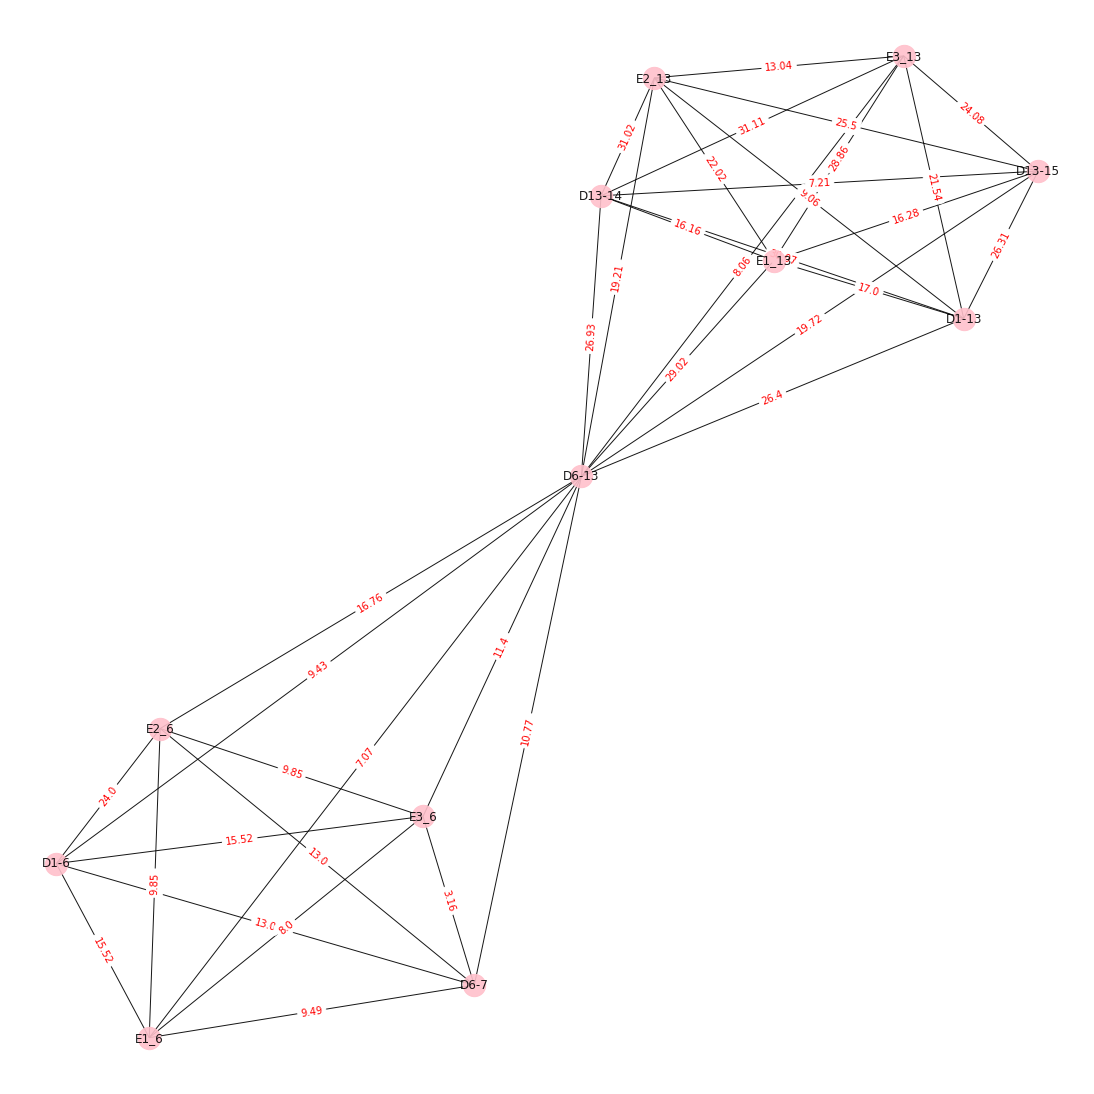

In [50]:
gm.plot(door_graph)

In [ ]:
graph.get_shortest_path(1, 3)


In [11]:
exs_r13 = ['D1-1','D1-2','D1-3','D1-4']
nods = [1,6,13]

exhibit_combinations = list(combinations(exs_r13, 2))

print(exhibit_combinations)

[('D1-1', 'D1-2'), ('D1-1', 'D1-3'), ('D1-1', 'D1-4'), ('D1-2', 'D1-3'), ('D1-2', 'D1-4'), ('D1-3', 'D1-4')]


('D1-1', 'D1-2')
('D1-1', 'D1-4')
('D1-2', 'D1-4')


[None, None, None]